In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
import torchvision.transforms as T
from torch.utils.data import DataLoader
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim import Adam
import numpy as np
from PIL import Image
import math
from typing import List
from torchvision.utils import make_grid

In [2]:
mnist_transform = T.Compose(
    [
        T.Resize((64, 64)),
        T.ToTensor(),
    ]
)

In [3]:
path = "data/mnist"

In [4]:
train_dataset = MNIST(path, train=True, transform=mnist_transform, download=True)
valid_dataset = MNIST(path, train=False, transform=mnist_transform, download=True)

In [5]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=8, pin_memory=True)

In [6]:
def train(model, train_loader):
    model.train()
    
    train_loss = 0
    
    for x, _ in tqdm(train_loader, desc="Train"):
        x = x.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, x)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    train_loss /= len(train_loader)
    
    return train_loss

In [7]:
@torch.inference_mode()
def evaluate(model, valid_loader):
    model.eval()
    
    total_loss = 0
    
    for x, _ in tqdm(valid_loader, desc="Eval"):
        x = x.to(device)
        output = model(x)
        loss = loss_fn(output, x)
        total_loss += loss.item()
        
    total_loss /= len(valid_loader)
    
    return total_loss

In [8]:
def plot_stats(
    train_loss: List[float],
    valid_loss: List[float],
    title: str
):
    plt.figure(figsize=(16, 8))
    plt.title(title + " loss")
    
    plt.plot(train_loss, label="Train loss")
    plt.plot(valid_loss, label="Valid_loss")
    plt.legend()
    plt.grid()
    plt.show()

In [27]:
@torch.inference_mode()
def visualize(model, xs):
    model.eval()
    
    to_pil = T.ToPILImage()
    outputs = model(xs.to(device)).cpu()
    
    plt.figure(figsize=(20, 4))
    plt.imshow(
        to_pil(
            torch.cat(
                (
                    make_grid(xs[: 10], nrow=10, pad_value=1),
                    make_grid(outputs[: 10], nrow=10, pad_value=1)
                ),
                dim=1
            )
        )
    )
    
    plt.axis("off")
    plt.show()

In [28]:
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    
    for epoch in range(num_epochs):
        train_loss = train(model, train_loader)
        valid_loss = evaluate(model, valid_loader)
        
        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        
        clear_output()
        
        visualize(model, next(iter(valid_loader))[0])
        
        plot_stats(
            train_loss_history,
            valid_loss_history,
            title
        )

In [29]:
class Block(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int = 1, upsample: bool = False):
        super().__init__()
        
        self.upsample = upsample
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=1,
            bias=False
        )
        
        self.norm = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        if self.upsample:
            x = nn.functional.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False, recompute_scale_factor=False)
        return self.act(self.norm(self.conv(x)))

In [33]:
class AutoEncoder(nn.Module):
    def __init__(self, in_channels: int, base_block: nn.Module = Block, base_size: int = 32, num_blocks: int = 4):
        super().__init__()
        
        self.base_size = base_size
        
        # encoder
        encoder_blocks = []
        
        for i in range(num_blocks):
            encoder_blocks.append(
                base_block(
                    in_channels=base_size if i else in_channels,
                    out_channels=base_size,
                    kernel_size=3,
                    stride=2
                )
            )
        
        encoder_blocks.append(
            base_block(
                in_channels=base_size,
                out_channels=base_size,
                kernel_size=3
            ).conv
        )
        
        self.encoder = nn.Sequential(*encoder_blocks)
        
        # decoder
        decoder_blocks = []
        
        for i in range(num_blocks):
            decoder_blocks.append(
                base_block(
                    in_channels=base_size,
                    out_channels=base_size,
                    kernel_size=3,
                    upsample=True
                )
            )
        
        decoder_blocks.append(
            base_block(
                in_channels=base_size,
                out_channels=in_channels,
                kernel_size=3
            ).conv
        )
        decoder_blocks.append(nn.Sigmoid())
        
        self.decoder = nn.Sequential(*decoder_blocks)
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x
    
    @torch.inference_mode()
    def encode(self, x):
        return self.flatten((self.encoder(x)))
    
    @torch.inference_mode()
    def decode(self, x):
        latent_size = int(math.sqrt(x.shape[1] // self.base_size))
        return self.decoder(x.view(-1, self.base_size, latent_size, latent_size))

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

loss_fn = nn.MSELoss()
model = AutoEncoder(in_channels=1).to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

cuda


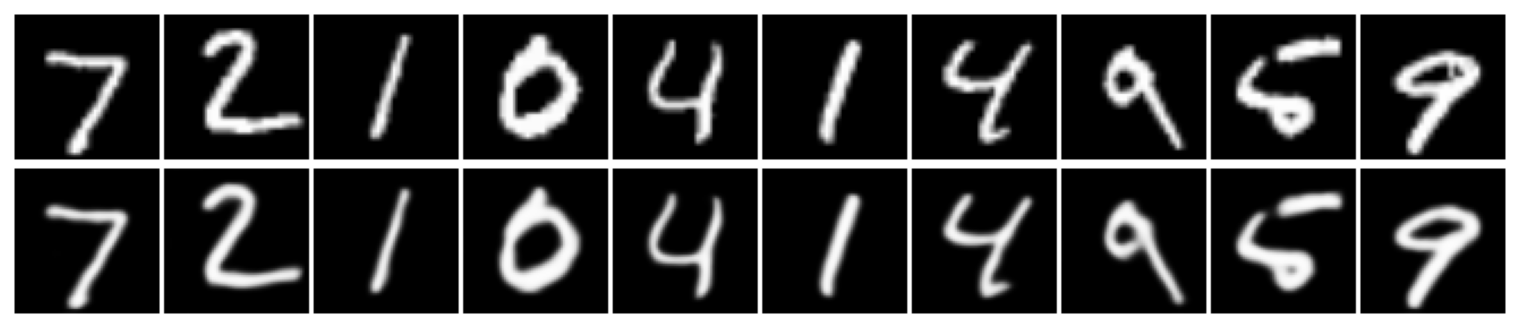

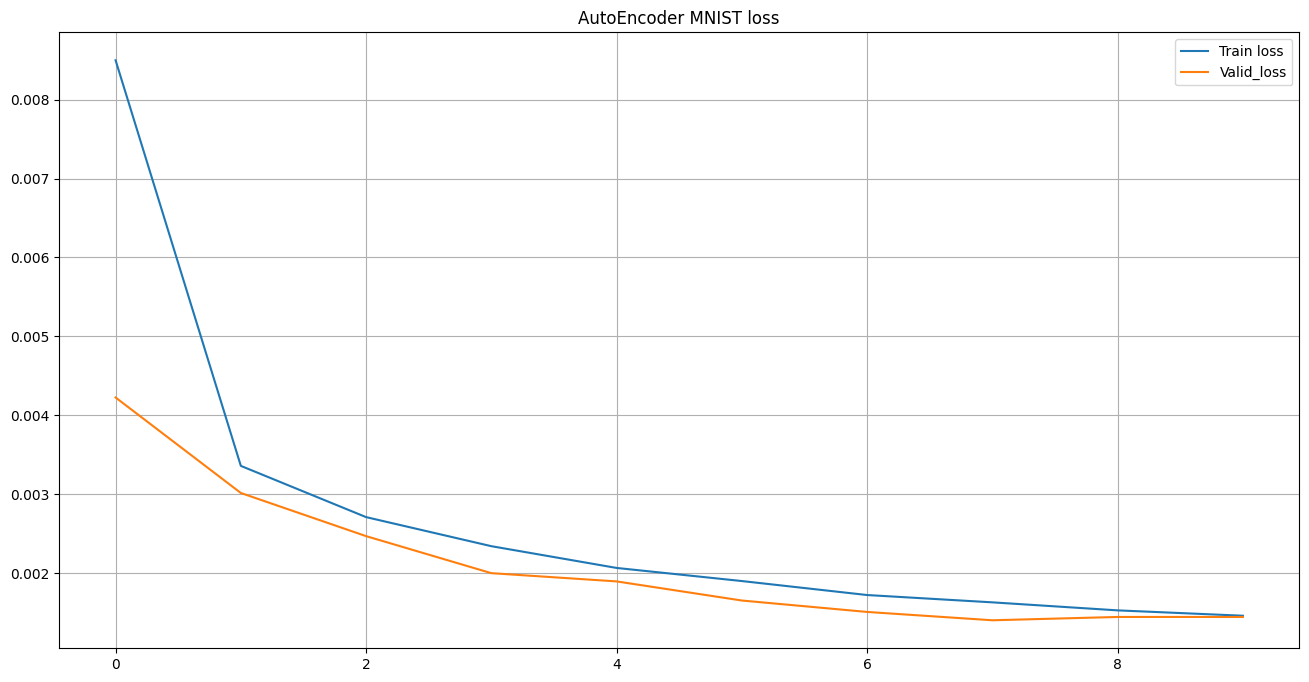

In [35]:
whole_train_valid_cycle(model, 10, "AutoEncoder MNIST")